#  Práctica Obligatoria - Parte II - MLP

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">MLPs</p>***

En esta parte, entrenarás varias redes MLPs y analizarás sus resultados en el dataset GTS.


### Evaluación - 3/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.25 puntos.
- **[Ejercicio 2]** 0.25 puntos.
- **[Ejercicio 3]** 0.5 puntos.
- **[Ejercicio 4]** 1 punto.
- **[Ejercicio 5]** 0.5 puntos.
- **[Ejercicio 6]** 0.5 puntos.

In [ ]:
!unzip data.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS


## Carga German Traffic Signs (GTS) dataset

Carga GTS en sus tres partes, como en el notebook anterior.

In [3]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

### **[Ejercicio 1]** Crear una `MLP` con una única capa oculta

In [ ]:

# Red neuronal MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        F1 = nn.Linear(input_size, hidden_size)     # Capa oculta
        Act = nn.Sigmoid()                          # Capa de activacion
        F_out = nn.Linear(hidden_size, output_size) # Capa de salida
        self.layers = nn.Sequential(F1, Act, F_out)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


### **[Ejercicio 2]** Crea una función que cuente el número de parámetros entrenables de un modelo

In [ ]:

def count_trainable_params(model: nn.Module) -> int:
    """
    Cuenta el número de parámetros entrenables en un modelo PyTorch.

    Args:
        model (nn.Module): El modelo de PyTorch.

    Returns:
        int: El número total de parámetros entrenables.
    """


    total_params = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
    return total_params


Instancia el modelo `MLP` que has creado antes y configúralo para que no tenga más de **200.000** parámetros:

In [ ]:

input_size = 1875
hidden_size = 100
output_size = 43
model = MLP(input_size, hidden_size, output_size)

trainable_params = count_trainable_params(model)
print(f"Número de parámetros entrenables: {trainable_params}")

Número de parámetros entrenables: 191943


### **[Ejercicio 3]** Crea las funciones de apoyo para el entrenamiento

Durante el entrenamiento, debes guardas las pérdidas de entrenamiento y validación para, posteriormente, graficarlas.

Para ello, guárdalas en un archivo `train_loss_mlp.csv` y otro `valid_loss_mlp.csv`.

Haz lo mismo para los *accuracies* `train_accuracy_mlp.csv` y `valid_accuracy_mlp.csv`.

In [ ]:

# Función de entrenamiento
def train(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        running_loss += loss.item()

        # Calcular la precisión
        predicted = torch.max(outputs, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# Función de evaluación
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()

            # Calcular la precisión
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# Función para entrenar y evaluar, guardando las pérdidas y precisiones en archivos CSV
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10, test_loader=None, name='None'):
    train_losses = []
    val_losses = []
    train_accuracies = []  # Lista para almacenar las precisiones de entrenamiento
    val_accuracies = []  # Lista para almacenar las precisiones de validación

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)  

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)                 

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir pérdidas y precisión
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Guardar pérdidas y precisión en archivos CSV
    train_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Loss': train_losses, 'Train Accuracy': train_accuracies})
    val_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Loss': val_losses, 'Validation Accuracy': val_accuracies})

    train_loss_df.to_csv(f'train_loss_{name}.csv', index=False)
    val_loss_df.to_csv(f'valid_loss_{name}.csv', index=False)

    # Evaluación en el conjunto de test (si se proporciona)
    if test_loader is not None:
        test_loss, test_accuracy = evaluate(model, test_loader, loss_fn, device) 
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Guardar la precisión de test en un archivo CSV
        test_accuracy_df = pd.DataFrame({'Test Accuracy': [test_accuracy]})
        test_accuracy_df.to_csv(f'test_accuracy_{name}.csv', index=False)

    # Guardar las precisiones de entrenamiento y validación en archivos CSV
    train_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Accuracy': train_accuracies})
    val_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Accuracy': val_accuracies})

    train_accuracy_df.to_csv(f'train_accuracy_{name}.csv', index=False)
    val_accuracy_df.to_csv(f'valid_accuracy_{name}.csv', index=False)

    return train_loss_df, val_loss_df, test_loss, test_accuracy



### **[Ejercicio 4]** Entrena el modelo solo 10 épocas.

Puedes hacer uso de la `gpu`, aunque no es necesario. De manera orientativa, 10 épocas en `cpu` deberían tardar menos de 90 segundos.

Para ellos, crea los dataloaders e instancia el modelo sin sobrepasar los 200.000 parámetros.

Usa una función de pérdida apropiada y el optimizador que consideres.


In [ ]:
device = 'cpu'
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = MLP(input_size, hidden_size, output_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# Entrenar y evaluar el modelo

train_loss_df, val_loss_df, test_loss, test_accuracy = train_and_evaluate(model, train_loader, valid_loader, loss_fn, optimizer, device, num_epochs, test_loader, name='mlp') # COMPLETAR


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Train Loss: 2.4572, Train Accuracy: 0.3641, Validation Loss: 1.6754, Validation Accuracy: 0.5509
Epoch [2/10], Train Loss: 1.3009, Train Accuracy: 0.6610, Validation Loss: 1.0533, Validation Accuracy: 0.7316
Epoch [3/10], Train Loss: 0.8569, Train Accuracy: 0.7913, Validation Loss: 0.7532, Validation Accuracy: 0.8116
Epoch [4/10], Train Loss: 0.6353, Train Accuracy: 0.8466, Validation Loss: 0.6093, Validation Accuracy: 0.8431
Epoch [5/10], Train Loss: 0.5075, Train Accuracy: 0.8796, Validation Loss: 0.4913, Validation Accuracy: 0.8840
Epoch [6/10], Train Loss: 0.4261, Train Accuracy: 0.8980, Validation Loss: 0.4528, Validation Accuracy: 0.8943
Epoch [7/10], Train Loss: 0.3624, Train Accuracy: 0.9135, Validation Loss: 0.3772, Validation Accuracy: 0.9069
Epoch [8/10], Train Loss: 0.3247, Train Accuracy: 0.9230, Validation Loss: 0.3773, Validation Accuracy: 0.8979
Epoch [9/10], Train Loss: 0.2892, Train Accuracy: 0.9297, Validation Loss: 0.3712, Validation Accuracy: 0.8984
E

Guarda el modelo pytorch con ayuda de las siguientes funciones, lo necesitarás más adelante.

Guárdalo con el nombre `mlp.pth`.

In [ ]:
def save_full_model(model, file_name):
    """
    Guarda el modelo completo, incluyendo la arquitectura y los pesos.

    Args:
        model: El modelo de PyTorch a guardar.
        file_name: El nombre del archivo donde se guardará el modelo.
    """
    torch.save(model, file_name)
    print(f"Modelo completo guardado como {file_name}")


def load_full_model(file_name):

    """
    Carga el modelo completo desde un archivo guardado.

    Args:
        file_name: El nombre del archivo del modelo guardado.

    Returns:
        model: El modelo cargado.
    """
    model = torch.load(file_name)
    print(f"Modelo cargado desde {file_name}")
    return model


save_full_model(model, 'mlp.pth')



Modelo completo guardado como mlp.pth


### **[Ejercicio 5]** Carga los datos de 'loss' y 'accuracy' que has generado y pinta las gráficas

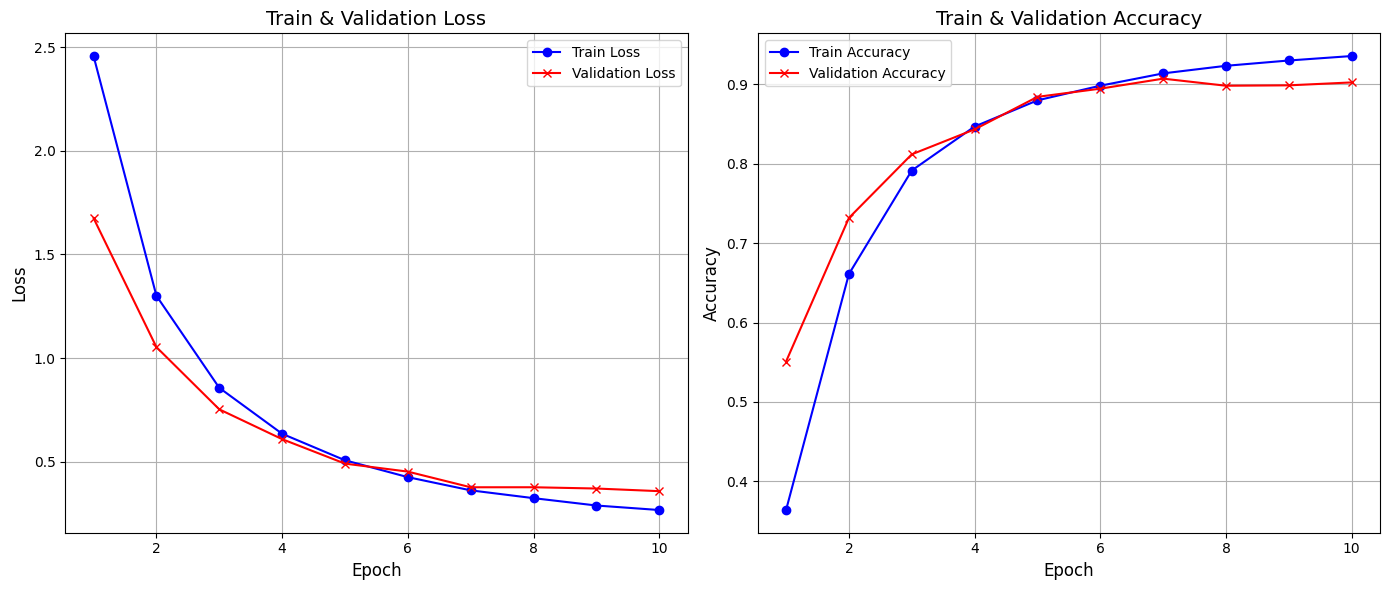

In [ ]:


def plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file):
    # Leer los archivos CSV con los datos
    train_loss_df = pd.read_csv(train_loss_file)
    valid_loss_df = pd.read_csv(valid_loss_file)
    train_accuracy_df = pd.read_csv(train_accuracy_file)
    valid_accuracy_df = pd.read_csv(valid_accuracy_file)

    # Configuración de la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de las pérdidas
    ax1.plot(train_loss_df['Epoch'], train_loss_df['Train Loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(valid_loss_df['Epoch'], valid_loss_df['Validation Loss'], label='Validation Loss', color='red', linestyle='-', marker='x')
    ax1.set_title('Train & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Gráfico de las precisiones
    ax2.plot(train_accuracy_df['Epoch'], train_accuracy_df['Train Accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
    ax2.plot(valid_accuracy_df['Epoch'], valid_accuracy_df['Validation Accuracy'], label='Validation Accuracy', color='red', linestyle='-', marker='x')
    ax2.set_title('Train & Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()



# Carga los datos y muéstralos
train_loss_file = 'train_loss_mlp.csv'
valid_loss_file = 'valid_loss_mlp.csv'
train_accuracy_file = 'train_accuracy_mlp.csv'
valid_accuracy_file = 'valid_accuracy_mlp.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

### **[Ejercicio 6]** Calcula la matriz de confusión y el porcentaje de error por clase

Modelo cargado desde mlp.pth


<ipython-input-13-ea0c12c2391b>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(file_name)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/data

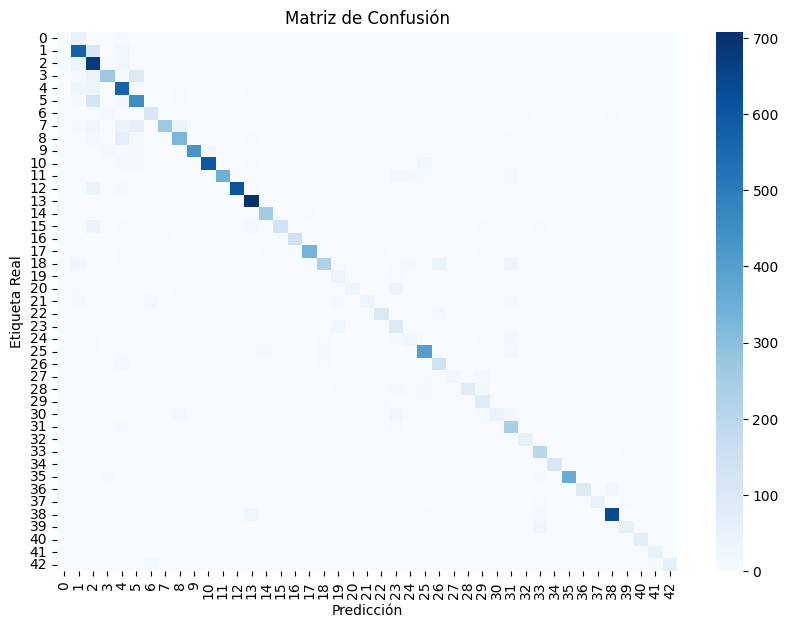

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, test_dataloader, device):
    """
    Genera y pinta la matriz de confusión de un modelo en PyTorch utilizando el DataLoader de prueba,
    y guarda la imagen resultante.

    Args:
        model: El modelo de PyTorch entrenado.
        test_dataloader: El DataLoader que contiene los datos de prueba.
        device: El dispositivo en el que se encuentra el modelo (CPU o GPU).
        filename: El nombre del archivo para guardar la imagen de la matriz de confusión.
    """
    # Poner el modelo en modo de evaluación
        

    all_preds = []
    all_labels = []

    # Desactivar el cálculo de gradientes (no se necesita para la inferencia)
    with torch.no_grad():
        for images, labels in test_dataloader:
            # Enviar las imágenes y las etiquetas al dispositivo correcto
            images, labels = images.to(device), labels.to(device) 

            # Obtener las predicciones del modelo
            outputs = model(images) 
            preds = torch.max(outputs, 1)[1] 

            # Almacenar las predicciones y las etiquetas reales
            all_preds.extend(preds.cpu().numpy())  # Convertir a CPU y luego a numpy
            all_labels.extend(labels.cpu().numpy())

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)    

    # Pintar la matriz de confusión usando seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

    return cm

model = load_full_model(file_name='mlp.pth')
cm = plot_confusion_matrix(model, test_loader, device=device)


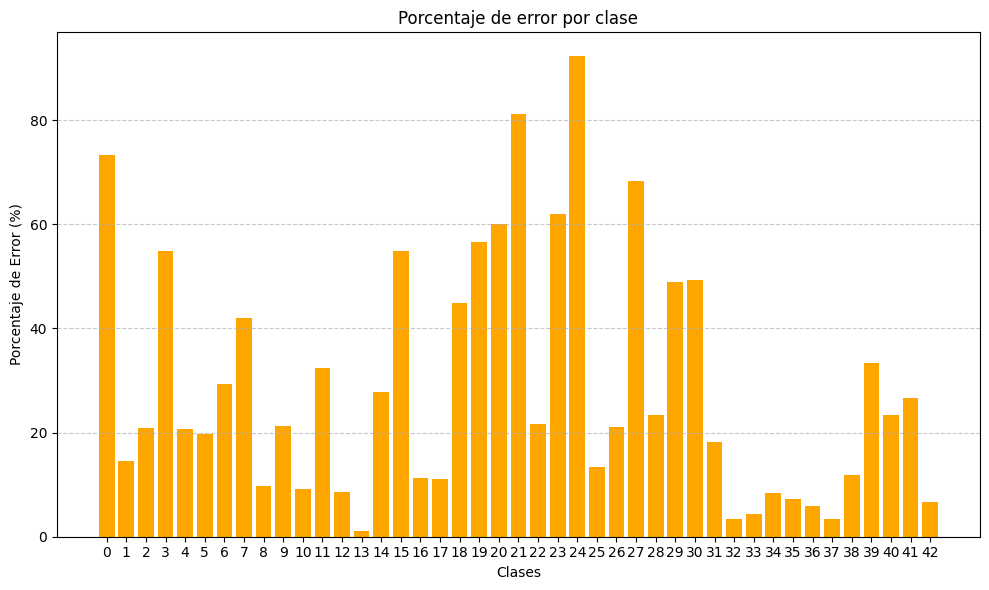

In [ ]:


def plot_error_per_class(cm, title="Porcentaje de error por clase"):
    """
    Calcula y visualiza el porcentaje de error por clase a partir de la matriz de confusión.

    Args:
        cm (numpy.ndarray): Matriz de confusión (2D array).
        title (str): Título del gráfico.
    """
    # Calcular el porcentaje de error por clase
    correct_per_class = np.diag(cm)
    total_per_class = np.sum(cm, axis=1)
    error_per_class = 1 - correct_per_class / total_per_class



    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(cm)), 100 * error_per_class, color='orange')
    plt.xlabel("Clases")
    plt.ylabel("Porcentaje de Error (%)")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(np.arange(len(cm)))
    plt.tight_layout()
    plt.show()


plot_error_per_class(cm)

## Guarda las funciones en un archivo llamado `utils.py`:

1. `count_trainable_params`
2. `train`
3. `evaluate`
4. `train_and_evaluate`
5. `save_full_model`
6. `load_full_model`
7. `plot_loss_accuracy`
8. `plot_confusion_matrix`
9. `plot_error_per_class`

## Guarda el modelo o modelos un archivo llamado `models.py`


---------------------